# 1-2 图片数据建模流程

## 1 准备数据

``cifar2``数据集是``cifar10``数据集的子集，只有两种类别，分别是:airplane和automobile，其中两者训练集各5000张, 测试集各有1000张

### 数据准备方式
一般在TensorFlow中准备数据图片有两种常用的方式:
* 使用tf.keras中的ImageDataGenerator工具
* 使用tf.data.Dataset搭配tf.image构建

In [10]:
# 使用第一种方式导入图片数据
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_gen = ImageDataGenerator(rescale = 1./255, rotation_range = 10)
train_data_iter = train_gen.flow_from_directory('../data/cifar2/train', class_mode = 'binary', target_size = (32, 32))
print(train_data_iter.class_indices)  # 想要把图片load出来需要python2的环境

Found 10000 images belonging to 2 classes.
{'airplane': 0, 'automobile': 1}


In [13]:
# tf.data.Dataset.list_files构建了文件路径的dataset
for img_path in tf.data.Dataset.list_files('../data/cifar2/train/*/*.jpg'):
    print(img_path)
    break

tf.Tensor(b'../data/cifar2/train/airplane/3357.jpg', shape=(), dtype=string)


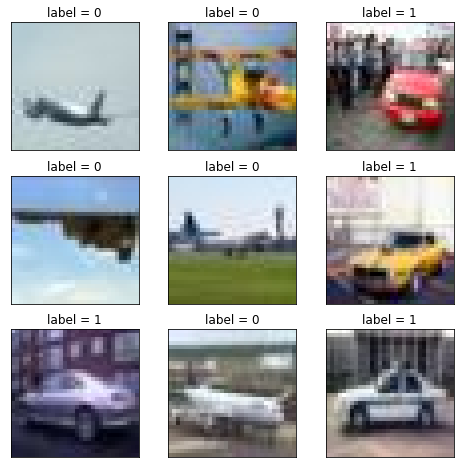

In [24]:
# 使用TensorFlow原生的方式导入图片
from tensorflow.keras import datasets, layers, models
batch_size = 100  # 定义常量

def load_image(img_path, size = (32, 32)):
    label = tf.constant(1, tf.int8) if tf.strings.regex_full_match(img_path, ".*/automobile/.*") else tf.constant(0, tf.int8)
    img = tf.io.read_file(img_path)  # return a Tensor of type string.
    img = tf.image.decode_jpeg(img)
    return (img, label)

def load_dataset(file_path):
    # 流式编程和并行处理
    return tf.data.Dataset.list_files(file_path) \
                .map(load_image, num_parallel_calls = tf.data.experimental.AUTOTUNE) \
                .batch(batch_size) \
                .prefetch(tf.data.experimental.AUTOTUNE) # This allows later elements to be prepared while the current element is being processed
    
ds_train = load_dataset('../data/cifar2/train/*/*.jpg')
ds_test = load_dataset('../data/cifar2/test/*/*.jpg')

# 查看部分样本
%matplotlib inline
from matplotlib import pyplot as plt
plt.figure(figsize = (8, 8))
for i, (img, label) in enumerate(ds_train.unbatch().take(9)):
    ax = plt.subplot(3, 3, i + 1)
    ax.imshow(img.numpy())
    ax.set_title("label = %d"%label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

In [27]:
# 在不unbatch的情况下可以直接迭代取batch
for batch_x, batch_y in ds_train.take(2):
    print(batch_x.shape, batch_y.shape)

(100, 32, 32, 3) (100,)
(100, 32, 32, 3) (100,)


## 2 定义模型

In [33]:
tf.keras.backend.clear_session()
x_input = layers.Input(shape = (32, 32, 3))
x = layers.Conv2D(filters = 32, kernel_size = (3, 3))(x_input)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(filters = 64, kernel_size = (5, 5))(x)
x = layers.MaxPool2D()(x)
x = layers.Dropout(rate = 0.1)(x)
x = layers.Flatten()(x)
x_output = layers.Dense(1, activation = 'sigmoid')(x)
model = tf.keras.Model(inputs = x_input, outputs = x_output)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0     

In [34]:
logdir = '1-2_keras_model_log/'
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq = 1)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss = tf.keras.losses.binary_crossentropy, metrics=['accuracy'])
history = model.fit(ds_train, epochs = 10, validation_data = ds_test, callbacks = [tensorboard_callback], workers = 4)

Epoch 1/10
100/100 [==============================] - 21s 212ms/step - loss: 9.7804 - accuracy: 0.7532 - val_loss: 1.3337 - val_accuracy: 0.8345
Epoch 2/10
100/100 [==============================] - 15s 154ms/step - loss: 1.6045 - accuracy: 0.8078 - val_loss: 1.1642 - val_accuracy: 0.8365
Epoch 3/10
100/100 [==============================] - 15s 155ms/step - loss: 1.4639 - accuracy: 0.8209 - val_loss: 1.2077 - val_accuracy: 0.8500
Epoch 4/10
100/100 [==============================] - 15s 154ms/step - loss: 1.4742 - accuracy: 0.8269 - val_loss: 1.1800 - val_accuracy: 0.8515
Epoch 5/10
100/100 [==============================] - 15s 154ms/step - loss: 1.5084 - accuracy: 0.8382 - val_loss: 1.1405 - val_accuracy: 0.8665
Epoch 6/10
100/100 [==============================] - 15s 154ms/step - loss: 1.5183 - accuracy: 0.8403 - val_loss: 1.6279 - val_accuracy: 0.8470
Epoch 7/10
100/100 [==============================] - 15s 154ms/step - loss: 1.5064 - accuracy: 0.8468 - val_loss: 1.2928 - val_ac

## 3 模型评估

In [39]:
# %load_ext tensorboard
# %tensorboard --logdir 1-2_keras_model_log/
from tensorboard import notebook
notebook.list()

No known TensorBoard instances running.


In [43]:
notebook.start('--logdir 1-2_keras_model_log/') # tensorboard在6006端口查看